In [2]:
# Install required libraries
!pip install pandas matplotlib seaborn requests

# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import csv
import requests


In [14]:
log_file_url = "https://raw.githubusercontent.com/devgupta2619/VRV_Python/refs/heads/main/sample.log"

response = requests.get(log_file_url)

if response.status_code == 200:
    log_data = response.text
    print("Log file loaded successfully.")
else:
    raise Exception("Failed to fetch log file. Please check the URL.")

Log file loaded successfully.



Parsed DataFrame:
               ip                   timestamp method   endpoint status
0    192.168.1.1  03/Dec/2024:10:12:34 +0000    GET      /home    200
1    203.0.113.5  03/Dec/2024:10:12:35 +0000   POST     /login    401
2       10.0.0.2  03/Dec/2024:10:12:36 +0000    GET     /about    200
3    192.168.1.1  03/Dec/2024:10:12:37 +0000    GET   /contact    200
4  198.51.100.23  03/Dec/2024:10:12:38 +0000   POST  /register    200

Requests per IP:
 ip
203.0.113.5      8
198.51.100.23    8
192.168.1.1      7
10.0.0.2         6
192.168.1.100    5
Name: count, dtype: int64

Most Frequently Accessed Endpoint: /login (Accessed 13 times)

Suspicious Activity Detected:
 ip
203.0.113.5    8
Name: count, dtype: int64


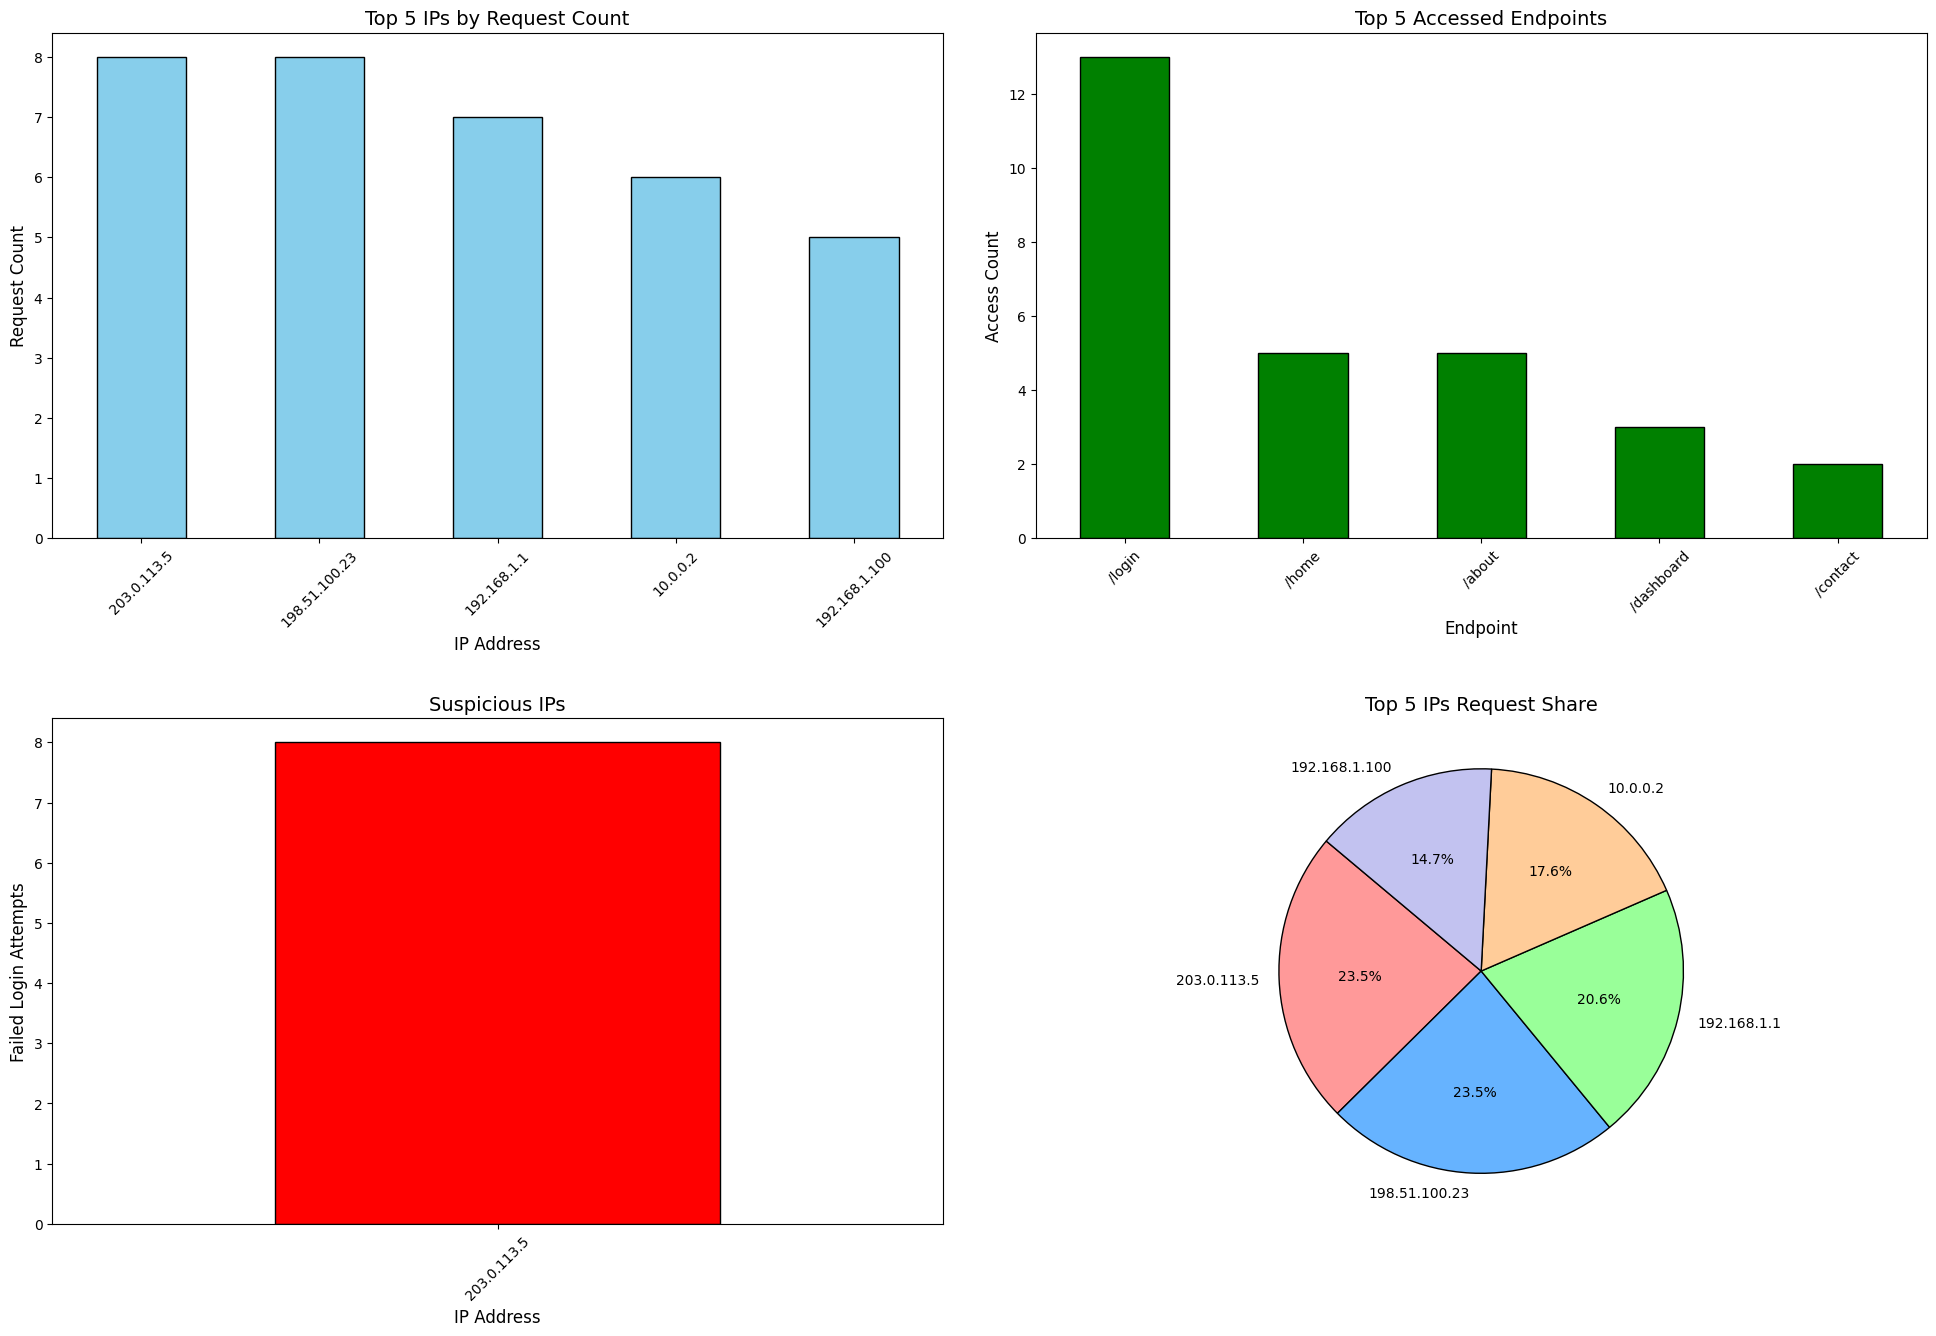

In [13]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import csv

# Function to parse the log file
def parse_log_to_dataframe(log_data):
    log_pattern = re.compile(
        r'(?P<ip>\d{1,3}(?:\.\d{1,3}){3}) - - \[(?P<timestamp>[^\]]+)] "(?P<method>[A-Z]+) (?P<endpoint>[^ ]+) [^"]+" (?P<status>\d{3})'
    )
    parsed_data = []
    for line in log_data.splitlines():
        match = log_pattern.search(line)
        if match:
            parsed_data.append(match.groupdict())
    return pd.DataFrame(parsed_data)



# Parse the log file into a DataFrame
df = parse_log_to_dataframe(log_data)
print("\nParsed DataFrame:\n", df.head())

# Count requests per IP
ip_counts = df['ip'].value_counts()
print("\nRequests per IP:\n", ip_counts.head())

# Most frequently accessed endpoint
endpoint_counts = df['endpoint'].value_counts()
most_accessed_endpoint = endpoint_counts.idxmax()
most_accessed_count = endpoint_counts.max()
print(f"\nMost Frequently Accessed Endpoint: {most_accessed_endpoint} (Accessed {most_accessed_count} times)")

# Detect suspicious activity
def detect_suspicious_activity(df, threshold=5):
    failed_attempts = df[df['status'] == '401']
    suspicious_ips = failed_attempts['ip'].value_counts()
    return suspicious_ips[suspicious_ips > threshold]

suspicious_ips = detect_suspicious_activity(df)
print("\nSuspicious Activity Detected:\n", suspicious_ips)

#Save Results to CSV
results_file = "log_analysis_results.csv"

with open(results_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Section 1: Requests per IP
    writer.writerow(["Requests per IP"])
    writer.writerow(["IP Address", "Request Count"])
    for ip, count in ip_counts.items():
        writer.writerow([ip, count])


    writer.writerow(["---", "---"])

    # Section 2: Most Accessed Endpoint
    writer.writerow(["Most Accessed Endpoint"])
    writer.writerow(["Endpoint", "Access Count"])  #
    for endpoint, count in endpoint_counts.items():
        writer.writerow([endpoint, count])


    writer.writerow(["---", "---"])

    # Section 3: Suspicious Activity
    writer.writerow(["Suspicious Activity"])
    writer.writerow(["IP Address", "Failed Login Count"])
    if not suspicious_ips.empty:
        for ip, count in suspicious_ips.items():
            writer.writerow([ip, count])
    else:
        writer.writerow(["No Suspicious Activity Detected", ""])


# Dashboard Visualization
def generate_dashboard(ip_counts, endpoint_counts, suspicious_ips):
    plt.figure(figsize=(20, 14))

    # Subplot 1: Top IPs
    plt.subplot(2, 2, 1)
    ip_counts.head(5).plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Top 5 IPs by Request Count', fontsize=14)
    plt.xlabel('IP Address', fontsize=12)
    plt.ylabel('Request Count', fontsize=12)
    plt.xticks(rotation=45)

    # Subplot 2: Endpoint Distribution
    plt.subplot(2, 2, 2)
    endpoint_counts.head(5).plot(kind='bar', color='green', edgecolor='black')
    plt.title('Top 5 Accessed Endpoints', fontsize=14)
    plt.xlabel('Endpoint', fontsize=12)
    plt.ylabel('Access Count', fontsize=12)
    plt.xticks(rotation=45)

    # Subplot 3: Suspicious IPs
    plt.subplot(2, 2, 3)
    if not suspicious_ips.empty:
        suspicious_ips.plot(kind='bar', color='red', edgecolor='black')
        plt.title('Suspicious IPs', fontsize=14)
        plt.xlabel('IP Address', fontsize=12)
        plt.ylabel('Failed Login Attempts', fontsize=12)
        plt.xticks(rotation=45)
    else:
        plt.text(0.5, 0.5, 'No Suspicious Activity', fontsize=16, ha='center', va='center')

    # Subplot 4: Pie Chart of Top IPs
    plt.subplot(2, 2, 4)
    ip_counts.head(5).plot.pie(
        autopct='%1.1f%%',
        startangle=140,
        colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0'],
        wedgeprops={'edgecolor': 'black'}
    )
    plt.title('Top 5 IPs Request Share', fontsize=14)
    plt.ylabel('')

    plt.tight_layout(pad=3.0)
    plt.show()

# Generate the dashboard
generate_dashboard(ip_counts, endpoint_counts, suspicious_ips)
